## Online learning with RIVER

## Read x_train and x_test

In [29]:
import pandas as pd
load = ""
X_train = pd.read_csv(f'../visualize dataset/datasets_after_transformation/eagle_data_all_completed_X_train.csv')
X_test = pd.read_csv(f'../visualize dataset/datasets_after_transformation/eagle_data_all_completed_X_test.csv')
y_train = pd.read_csv(f'../visualize dataset/datasets_after_transformation/eagle_data_all_completed_y_train.csv')
y_test = pd.read_csv(f'../visualize dataset/datasets_after_transformation/eagle_data_all_completed_y_test.csv')

print(len(X_train), len(X_test), len(y_train), len(y_test))

18306 2937 18306 2937


In [ ]:
y_train = y_train.squeeze()
y_test = y_test.squeeze()

## Extract only best features

In [ ]:
features_firt_approach = ['job_id', 'qos', 'gpus_req', 'user_account_name', 'processors_req_nodes',
'nodes_req_mem', 'processors_req_mem', 'partition_wallclock']

features_second_approach = ['partition_wallclock', 'program_type_job_type_qos_partition_ratio_runtime_ema', 'program_type_job_type_wallclock_avg_runtime_seen', 'processors_req_mem']


X_train_final = X_train[features_firt_approach]
X_test_final = X_test[features_firt_approach]

## Function for evaluation

In [ ]:
def evaluate_model(model, X, y, label, raw_X, use_log=True):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

    if isinstance(y, pd.DataFrame):
        y = y.squeeze()

    y_pred = []

    # Check if this is a River model (online)
    if hasattr(model, "predict_one") and hasattr(model, "learn_one"):
        for xi, yi in zip(X.to_dict(orient="records"), y):
            pred = model.predict_one(xi)
            y_pred.append(pred)

            # Only update model if not on training set
            if label != "x_train":
                model.learn_one(xi, yi)

    elif hasattr(model, "predict"):  # scikit-learn-like batch model
        y_pred = model.predict(X)
    else:
        raise AttributeError("Model does not support `predict` or `predict_one/learn_one`")

    # Inverse log-transform if needed
    if use_log:
        y = np.exp(y)
        y_pred = np.exp(y_pred)

    y_pred = np.array(y_pred)



    # Main line plot
    plt.figure(figsize=(14, 5))
    plt.plot(y.values, label="Actual", color='gold')
    plt.plot(y_pred, label="Predicted", color='limegreen', linestyle='--', alpha=0.4)
    plt.title("Aligned Predicted vs Actual Job Runtimes")
    plt.xlabel("Job Index")
    plt.ylabel("Runtime")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Metrics
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    print(f"\n----- {label} (All Jobs) -----")
    print(f"R² Score: {r2:.3f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"Mean actual: {np.mean(y):.2f}")
    print("y shape:", y.shape)
    print("y_pred shape:", y_pred.shape)

    wallclock = raw_X['wallclock_req']
    # Conditions
    # --- Acceptance zone (runtime <= predicted < wallclock)
    accepted = (y <= y_pred) & (y_pred < wallclock)  
    under = y_pred < y
    over = y_pred > wallclock 
    tolerance = 1e-6
    exact = (y_pred >= y) & (y_pred <= y + tolerance)
    # floating point safe equality
    negative = y_pred < 0

    # Percentages
    total = len(y)
    pct_accepted = 100 * accepted.sum() / total
    pct_under = 100 * under.sum() / total
    pct_over = 100 * over.sum() / total
    pct_exact = 100 * exact.sum() / total
    pct_negative = 100 * negative.sum() / total

    # Plot
    plt.figure(figsize=(9, 6))
    plt.scatter(y_pred[accepted], y[accepted], color='limegreen',
                label=f'Accepted ({pct_accepted:.1f}%)', alpha=0.7)
    plt.scatter(y_pred[under], y[under], color='red',
                label=f'Underestimated ({pct_under:.1f}%)', alpha=0.7)
    plt.scatter(y_pred[over], y[over], color='orange',
                label=f'Overestimated ({pct_over:.1f}%)', alpha=0.7)
    if exact.sum() > 0:
        plt.scatter(y_pred[exact], y[exact], color='blue', marker='x',
                    label=f'Exact Match ({pct_exact:.2f}%)', alpha=0.9)
    if negative.sum() > 0:
        plt.scatter(y_pred[negative], y[negative], color='black', marker='v',
                    label=f'Negative Prediction ({pct_negative:.2f}%)', alpha=0.9)

    # Decorations
    plt.xlabel("Predicted Runtime")
    plt.ylabel("Actual Runtime")
    plt.title("Prediction Zones")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Job length stats
    if 'job_length' in raw_X.columns:
        print("\n----- Per Job length Evaluation -----")
        for jl in sorted(raw_X['job_length'].unique()):
            idx = raw_X['job_length'] == jl
            print(f"\n[Job Length {jl}]")
            print(f"  R²: {r2_score(y[idx], y_pred[idx]):.3f}")
            print(f"  MAE: {mean_absolute_error(y[idx], y_pred[idx]):.2f}")
            print(f"  RMSE: {np.sqrt(mean_squared_error(y[idx], y_pred[idx])):.2f}")
            print(f"  Samples: {np.sum(idx)}")

        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=y_pred, y=y, hue=raw_X["job_length"], alpha=0.8)
        max_val = max(y.max(), y_pred.max())
        plt.plot([0, max_val], [0, max_val], 'r--')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel("Predicted Runtime (log)")
        plt.ylabel("Actual Runtime (log)")
        plt.title("Predicted vs Actual by Job Length")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Job type stats
    if 'job_type' in raw_X.columns:
        print("\n----- Per Job type Evaluation -----")
        for jt in sorted(raw_X['job_type'].unique()):
            idx = raw_X['job_type'] == jt
            print(f"\n[Job Type {jt}]")
            print(f"  R²: {r2_score(y[idx], y_pred[idx]):.3f}")
            print(f"  MAE: {mean_absolute_error(y[idx], y_pred[idx]):.2f}")
            print(f"  RMSE: {np.sqrt(mean_squared_error(y[idx], y_pred[idx])):.2f}")
            print(f"  Samples: {np.sum(idx)}")

    # Time-based plots
    raw_X = raw_X.copy()
    raw_X['submit_time'] = pd.to_datetime(raw_X['submit_time'], unit='s', errors='coerce')
    df_temp = pd.DataFrame({
        'submit_time': raw_X['submit_time'],
        'actual': y,
        'predicted': y_pred,
        'wallclock': wallclock
    })

    if 'x_test' in label.lower():
        df_temp['day'] = df_temp['submit_time'].dt.date
        for day, group in df_temp.groupby('day'):
            print(f"\n--- Day: {day} | Samples: {len(group)} ---")

            # Plot 1: MAE Line Plot
            abs_errors = np.abs(group['actual'] - group['predicted'])
            plt.figure(figsize=(8, 4))
            plt.plot(abs_errors.values, color='crimson')
            plt.title(f"Absolute Error per Job for {day}")
            plt.xlabel("Job Index")
            plt.ylabel("Absolute Error")
            plt.grid(True, linestyle='--', alpha=0.3)
            plt.tight_layout()
            plt.show()

            # Plot 2: Runtime Comparison (first 40)
            n = min(40, len(group))
            plt.figure(figsize=(10, 5))
            plt.plot(range(n), group['actual'].values[:n], label='Actual', marker='o', color='gold')
            plt.plot(range(n), group['predicted'].values[:n], label='Predicted', marker='s', linestyle='--', color='limegreen')
            plt.plot(range(n), group['wallclock'].values[:n], label='Wallclock', marker='^', linestyle=':', color='skyblue')
            plt.title(f"Runtime Comparison for {day} (First {n} Jobs)")
            plt.xlabel("Job Index")
            plt.ylabel("Runtime (seconds)")
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.3)
            plt.tight_layout()
            plt.yscale('log')
            plt.show()

    else:
        df_temp['week'] = df_temp['submit_time'].dt.to_period('W').dt.start_time
        mae_over_time = []
        for week, group in df_temp.groupby('week'):
            mae = mean_absolute_error(group['actual'], group['predicted'])
            mae_over_time.append((week, mae))

        if mae_over_time:
            weeks, maes = zip(*mae_over_time)
            plt.figure(figsize=(10, 5))
            plt.plot(weeks, maes, marker='o', color='purple')
            plt.title("MAE over Time (Weekly)")
            plt.xlabel("Week")
            plt.ylabel("MAE")
            plt.xticks(rotation=45)
            plt.grid(True, linestyle='--', alpha=0.3)
            plt.tight_layout()
            plt.show()

        # Final comparison of actual vs predicted vs wallclock (first 80)
        n = 80
        plt.figure(figsize=(12, 6))
        plt.plot(range(n), y[:n], label="Actual", color="gold", marker="o")
        plt.plot(range(n), y_pred[:n], label="Predicted", color="limegreen", linestyle="--", marker="s")
        plt.plot(range(n), df_temp['wallclock'][:n], label="Wallclock", color="skyblue", linestyle=":", marker="^")
        plt.title(f"Comparison of Actual, Predicted, and Wallclock Runtimes (First {n} Jobs)")
        plt.xlabel("Job Index")
        plt.ylabel("Runtime (seconds)")
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.3)
        plt.tight_layout()
        plt.yscale('log')
        plt.show()

    # Negative predictions
    y_pred_series = pd.Series(y_pred, index=X.index)
    negative_idx = y_pred_series[y_pred_series < 0].index
    negative_features = X.loc[negative_idx].copy()
    negative_features['prediction'] = y_pred_series.loc[negative_idx]
    print(f"Number of negative predictions: {len(negative_features)}")


In [ ]:
# pip install river

In [ ]:
from river.ensemble import BaggingRegressor
from river.tree import HoeffdingTreeRegressor
from river import metrics
from tqdm import tqdm


# Init model and metric
base_model = HoeffdingTreeRegressor(
    max_depth=5,          # Limit depth
    grace_period=250,      # Less frequent splits
    delta=1e-5,            # High confidence
    min_samples_split=40   # Require more data to split
)

# base_model = HoeffdingTreeRegressor(
#     max_depth=5,          # Limit depth
#     grace_period=300,      # Less frequent splits
#     delta=1e-5,            # High confidence
#     min_samples_split=40   # Require more data to split
# )

model = BaggingRegressor(model=base_model)
metric = metrics.MAE()

# Prepare training set
X_dicts = X_train_final.to_dict(orient="records")

# Train and evaluate
for x, y in tqdm(zip(X_dicts, y_train), total=len(y_train), desc="Final training"):
    y_pred = model.predict_one(x)
    model.learn_one(x, y)
    metric.update(y_true=y, y_pred=y_pred)

print(f"\n✅ Final Training MAE (using selected features): {metric.get():.4f}")

Final training: 100%|██████████| 18306/18306 [00:33<00:00, 554.22it/s]


✅ Final Training MAE (using selected features): 162483494849.8434


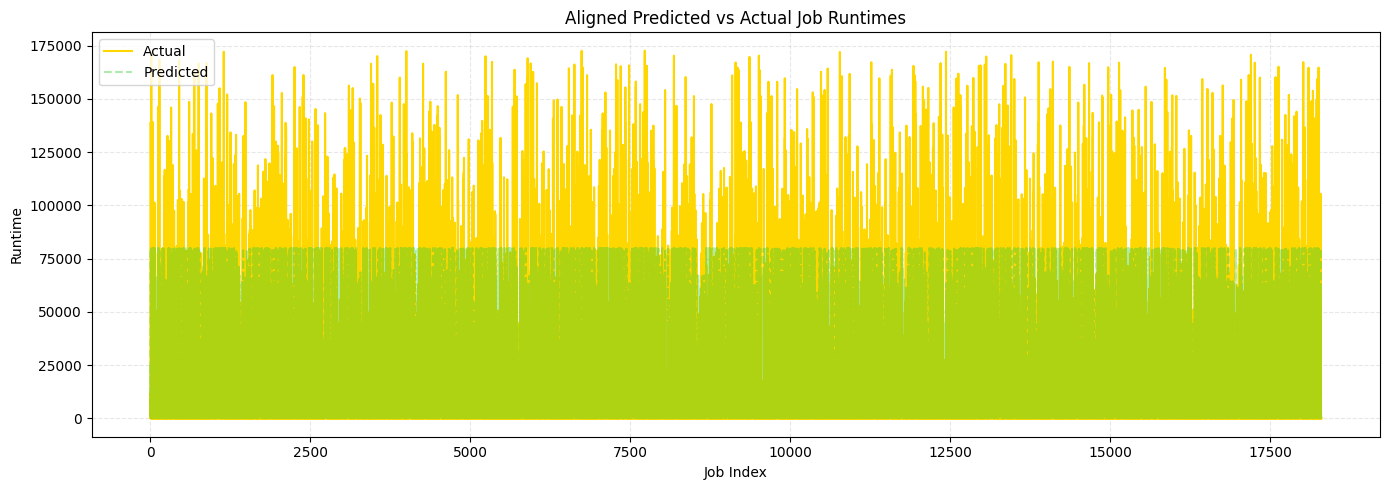


----- x_train (All Jobs) -----
R² Score: 0.631
MAE: 8642.76
RMSE: 19096.87
Mean actual: 13816.37
y shape: (18306,)
y_pred shape: (18306,)


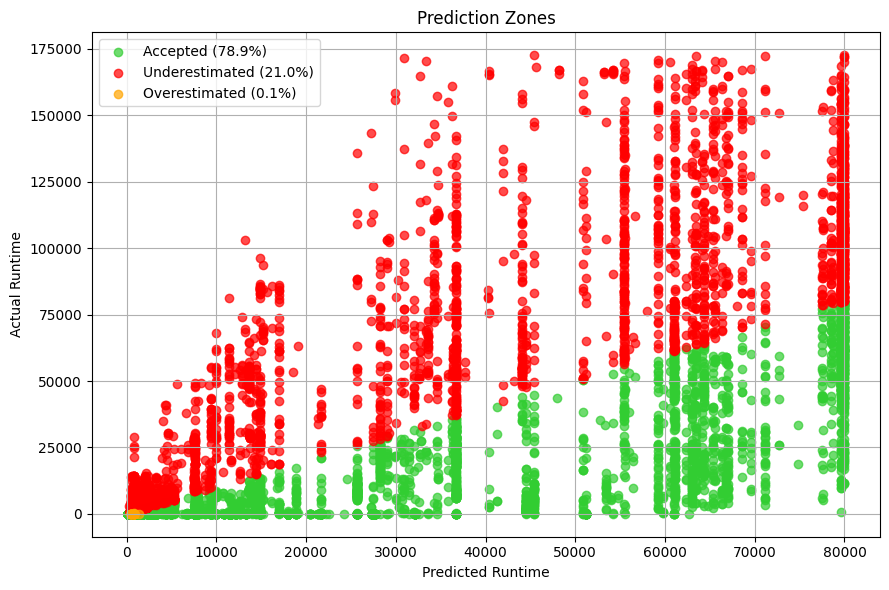


----- Per Job length Evaluation -----

[Job Length long]
  R²: 0.396
  MAE: 23290.57
  RMSE: 33416.23
  Samples: 5415

[Job Length medium]
  R²: -330.722
  MAE: 3250.52
  RMSE: 9328.41
  Samples: 1375

[Job Length short]
  R²: -3039.403
  MAE: 2398.97
  RMSE: 6653.07
  Samples: 11516


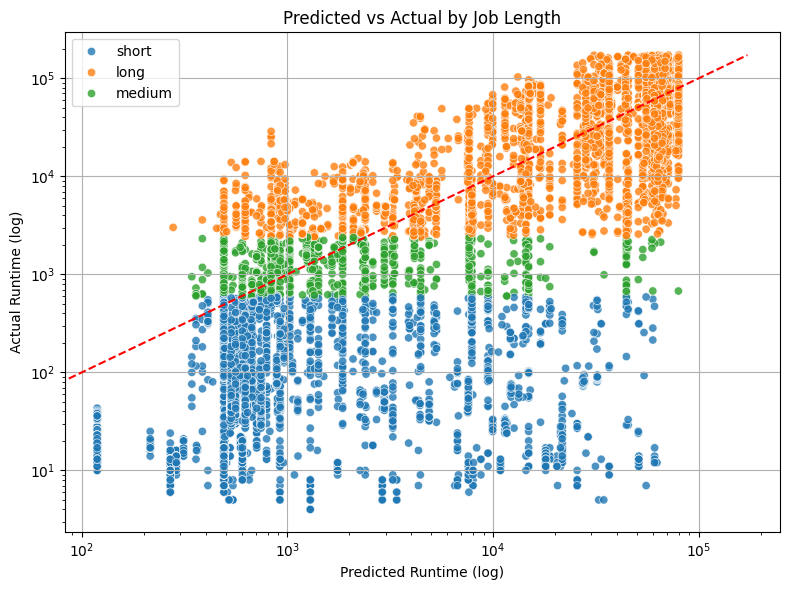


----- Per Job type Evaluation -----

[Job Type distributed]
  R²: 0.205
  MAE: 18296.23
  RMSE: 31605.98
  Samples: 904

[Job Type distributed_gpu]
  R²: -4.240
  MAE: 13421.64
  RMSE: 15944.56
  Samples: 35

[Job Type multithreaded]
  R²: 0.595
  MAE: 18513.79
  RMSE: 28823.83
  Samples: 5085

[Job Type serial]
  R²: 0.497
  MAE: 3834.19
  RMSE: 11091.54
  Samples: 11854

[Job Type single_node_gpu]
  R²: 0.435
  MAE: 3765.71
  RMSE: 13764.65
  Samples: 428


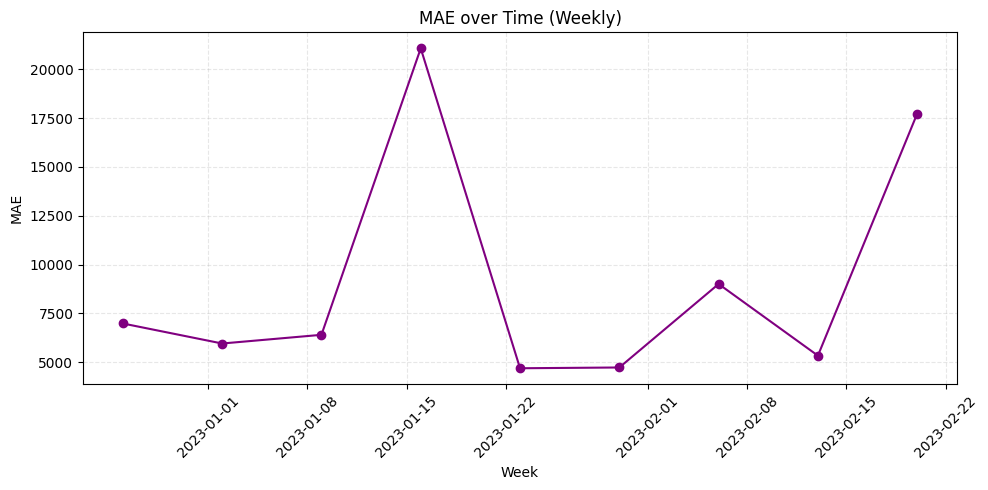

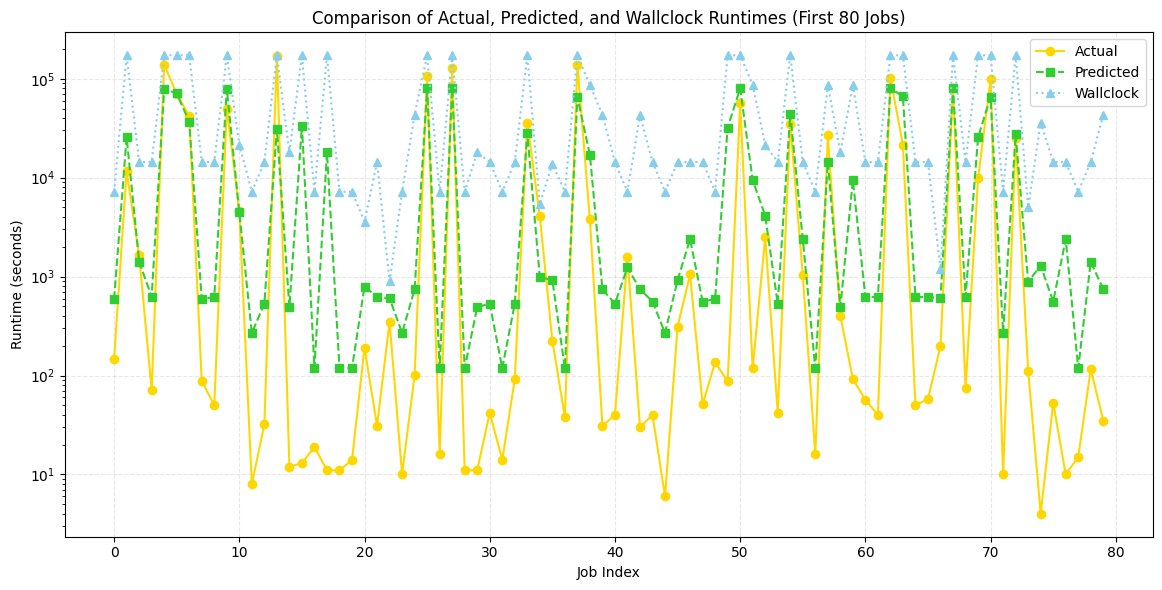

Number of negative predictions: 0


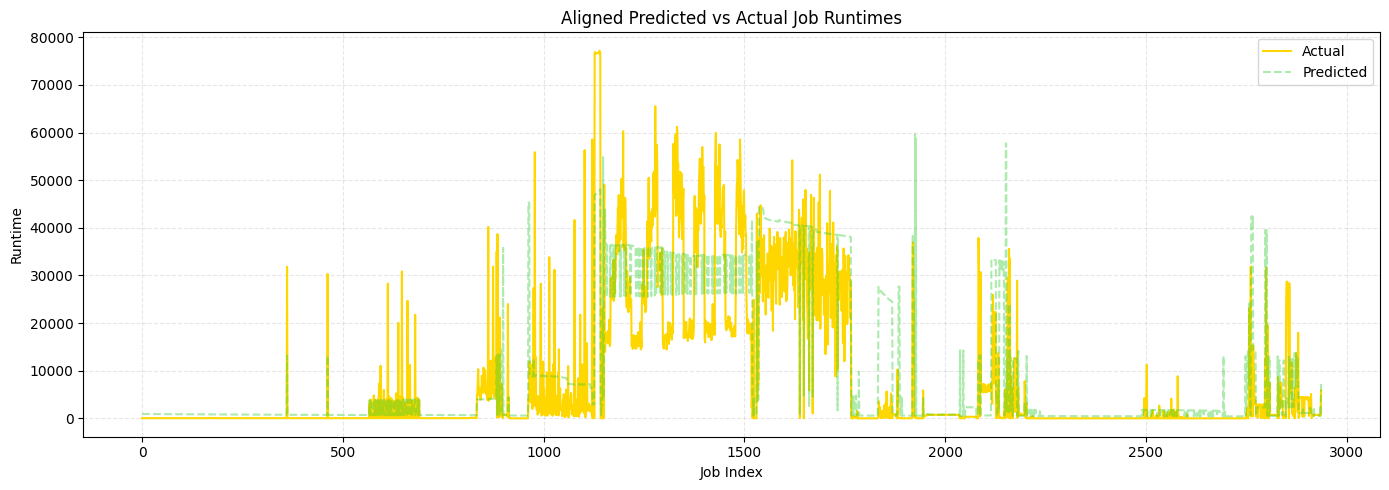


----- x_test (All Jobs) -----
R² Score: 0.622
MAE: 4811.51
RMSE: 8889.77
Mean actual: 8000.30
y shape: (2937,)
y_pred shape: (2937,)


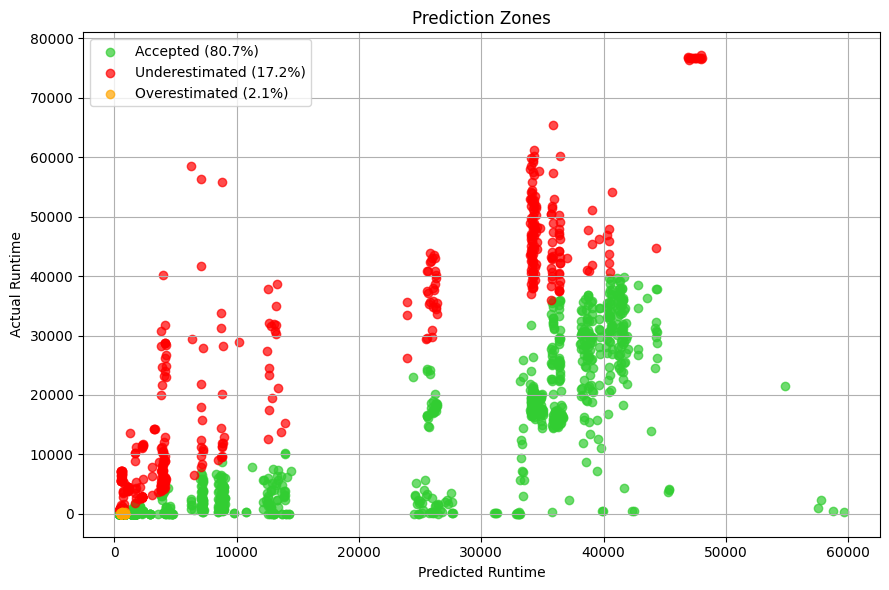


----- Per Job length Evaluation -----

[Job Length long]
  R²: 0.366
  MAE: 10367.82
  RMSE: 13025.42
  Samples: 1000

[Job Length medium]
  R²: -308.394
  MAE: 3794.84
  RMSE: 8466.33
  Samples: 274

[Job Length short]
  R²: -3114.947
  MAE: 1637.87
  RMSE: 5073.35
  Samples: 1663


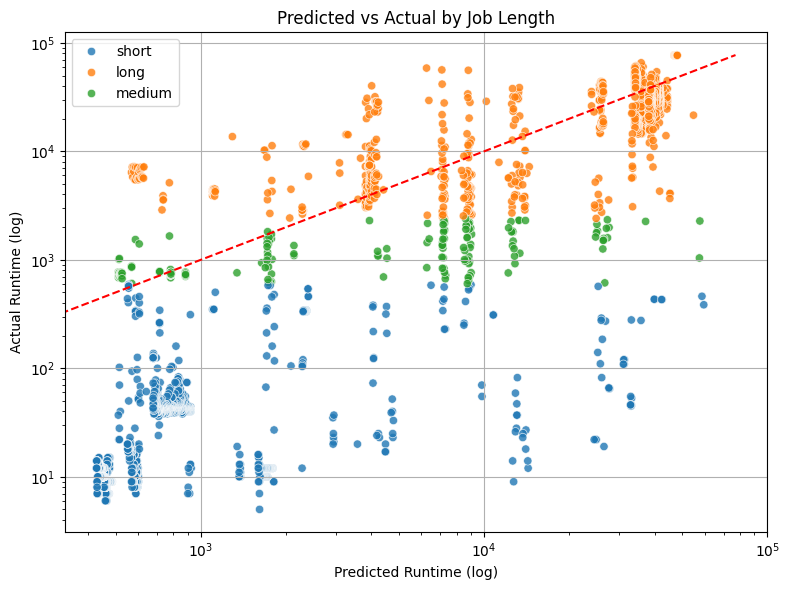


----- Per Job type Evaluation -----

[Job Type distributed]
  R²: -2.773
  MAE: 10598.23
  RMSE: 14540.51
  Samples: 117

[Job Type distributed_gpu]
  R²: -0.806
  MAE: 3198.78
  RMSE: 4549.85
  Samples: 9

[Job Type multithreaded]
  R²: 0.416
  MAE: 10199.95
  RMSE: 13664.09
  Samples: 516

[Job Type serial]
  R²: 0.707
  MAE: 3326.31
  RMSE: 6946.19
  Samples: 2235

[Job Type single_node_gpu]
  R²: -2.031
  MAE: 2752.19
  RMSE: 7075.19
  Samples: 60

--- Day: 2023-02-20 | Samples: 1519 ---


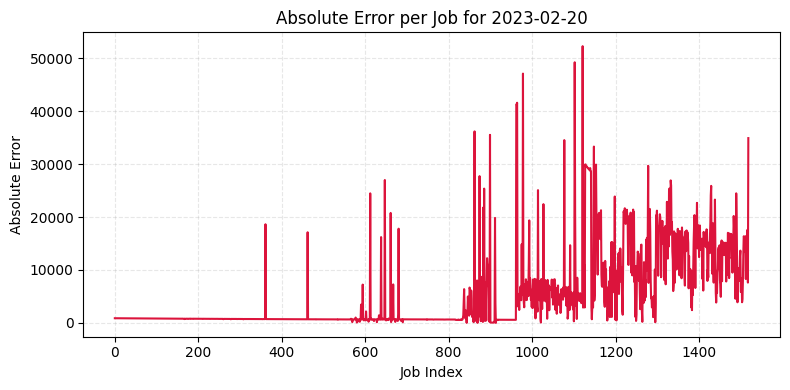

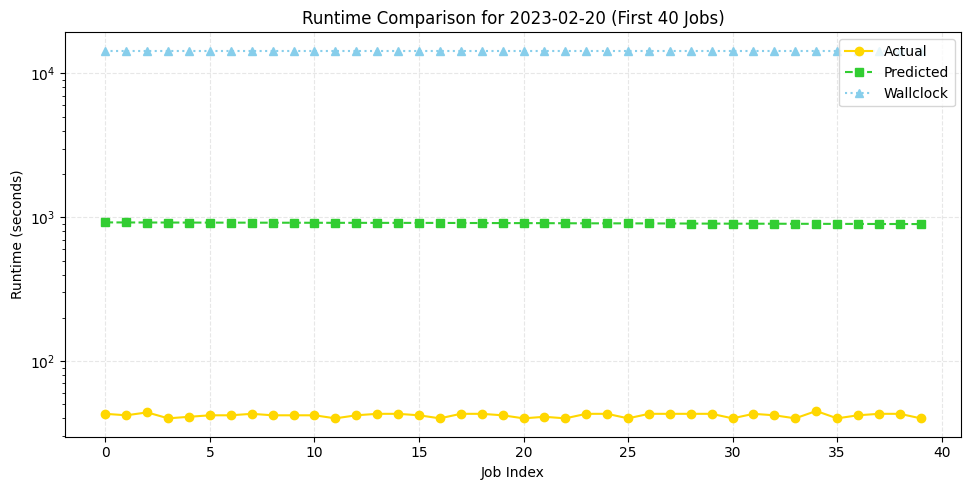


--- Day: 2023-02-21 | Samples: 1418 ---


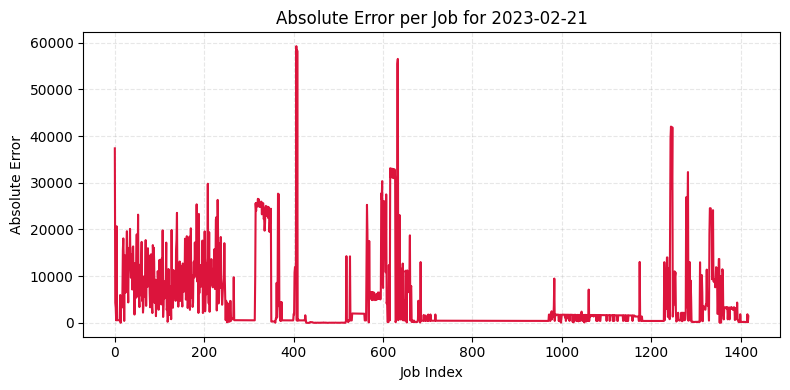

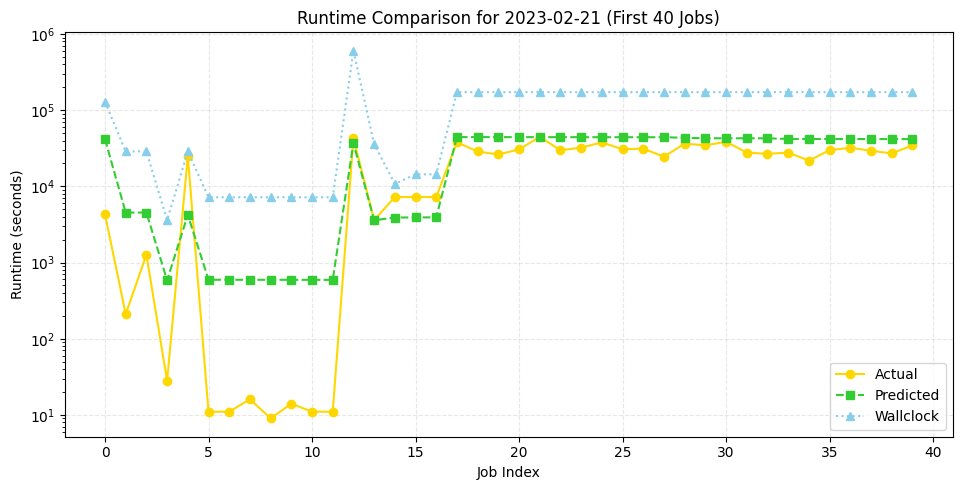

Number of negative predictions: 0


In [111]:
# Evaluate using your existing evaluate_model function
evaluate_model(model, X_train_final, y_train, "x_train", X_train, False)
evaluate_model(model, X_test_final, y_test, "x_test", X_test, False)